# Variation Autoencoder

| **Team Member**                 | **Area of Contribution**                                         |
|----------------------------------|------------------------------------------------------------------|
| **Dhanush Chandar Sivakumar**    | **Data Augmentation, Sampling Layer, and Encoder Network**       |
| **Rajesh Jayaraman**            | **Decoder Model, Loss Function, and Image Reconstruction**      |


11/11 [==============================] - 1s 47ms/step


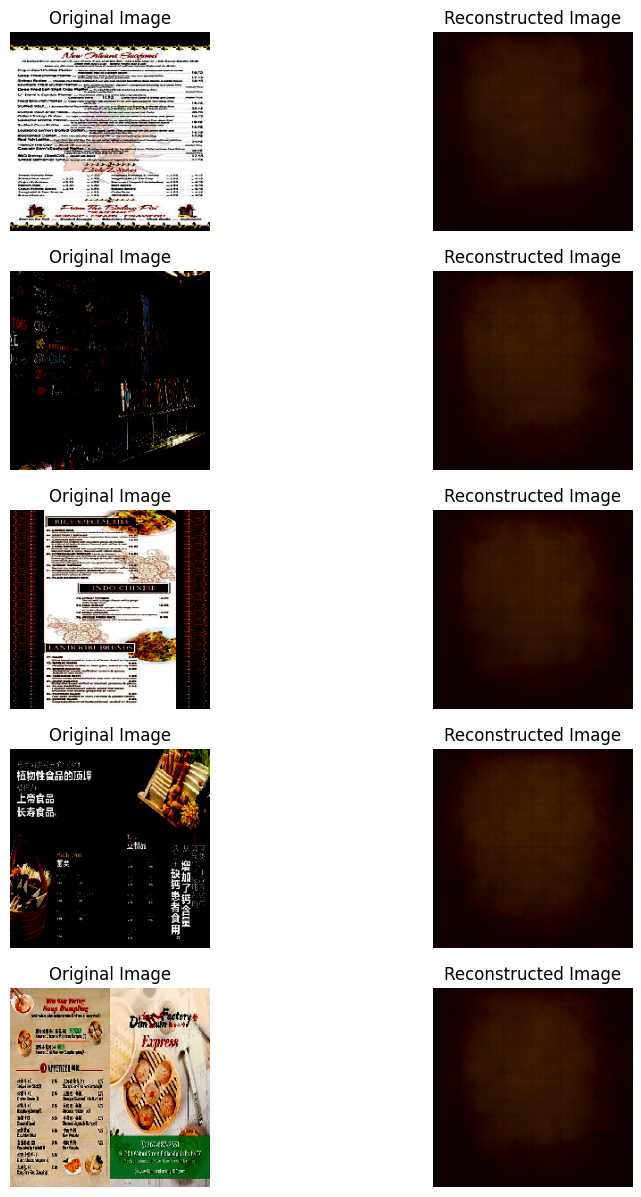

In [ ]:
vae.evaluate(X_test, X_test)
import matplotlib.pyplot as plt
reconstructed_images = vae.predict(X_test)
fig, axs = plt.subplots(5, 2, figsize=(10, 15))
for i in range(5):
    axs[i, 0].imshow(X_test[i])
    axs[i, 0].axis('off')
    axs[i, 0].set_title("Original Image")

    axs[i, 1].imshow(reconstructed_images[i])
    axs[i, 1].axis('off')
    axs[i, 1].set_title("Reconstructed Image")

plt.show()


Extremely poor results, incomplete model evaluation due to constant instance crashes in colab. 
Introduction of additional layers and hyperparameter tuning might aid improving the model

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from PIL import Image
from skimage.segmentation import mark_boundaries
import seaborn as sns
import pickle
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading images from file
images = np.load('/content/drive/My Drive/images.npy')

# Loading labels from file
labels = np.load('/content/drive/My Drive/labels.npy')

print(f"Images loaded: {images.shape}")
print(f"Labels loaded: {labels.shape}")

Images loaded: (8390, 224, 224, 3)
Labels loaded: (8390,)


In [ ]:
labels_unique = np.unique(labels)
print(f"Unique labels: {labels_unique}")

Unique labels: ['drink' 'food' 'inside' 'menu' 'outside']


Total images for class 'menu': (1678, 224, 224, 3)


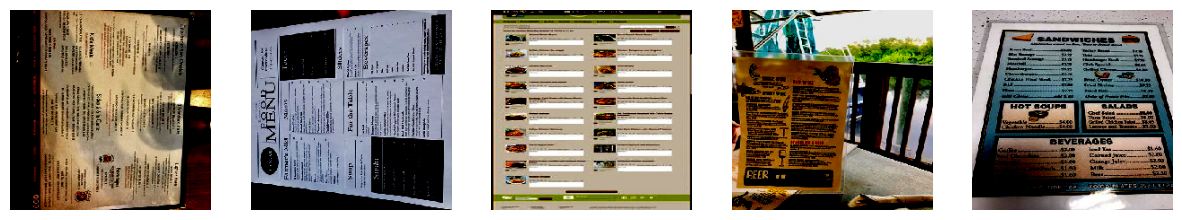

In [ ]:
# Separate images by class
selected_class = 'menu'
class_indices = np.where(labels == selected_class)[0]
class_images = images[class_indices]

print(f"Total images for class '{selected_class}': {class_images.shape}")

# Plot the images
num_images = 5
fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
for i in range(num_images):
    axs[i].imshow(class_images[i, :, :, :])  # Display RGB images
    axs[i].axis('off')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(class_images, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (1342, 224, 224, 3)
Test set size: (336, 224, 224, 3)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras import Model, layers

class VAE(Model):
    class Sampling(layers.Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def __init__(self, img_shape, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)

        self.img_shape = img_shape
        self.latent_dim = latent_dim

        inputs = tf.keras.Input(shape=img_shape)         # Encoder network
        x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
        x = BatchNormalization()(x)
        x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = BatchNormalization()(x)
        x = Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
        x = BatchNormalization()(x)
        x = Flatten()(x)
        x = Dense(256, activation="relu")(x)
        mean = Dense(latent_dim, name="mean")(x)
        log_var = Dense(latent_dim, name="log_var")(x)

        sampled = self.Sampling()([mean, log_var])

        self.encoder = Model(inputs, [sampled, mean, log_var], name="Encoder") # Encoder model

        latent_input = tf.keras.Input(shape=(latent_dim,)) # Decoder network
        y = Dense(128, activation="relu")(latent_input)
        y = Dense(14 * 14 * 16, activation="relu")(y)
        y = Reshape((14, 14, 16))(y)


        y = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(y)   # Upsampling layers to achieve 224x224x3 output
        y = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(y)
        y = Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(y)
        output = Conv2DTranspose(3, 3, activation="tanh", strides=2, padding="same")(y)

        # Create decoder model
        self.decoder = Model(latent_input, output, name="Decoder")

        # Loss trackers
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def call(self, x):
        sampled, _, _ = self.encoder(x)
        decoded = self.decoder(sampled)
        return decoded

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]


    def train_step(self, data):
        with tf.GradientTape() as tape:
            encoded, mean, log_var = self.encoder(data)
            decoded = self.decoder(encoded)

            recon_loss = tf.keras.losses.mean_squared_error(data, decoded)
            recon_loss = tf.reduce_mean(recon_loss)

            # Compute KL divergence loss
            kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
            kl_loss = tf.reduce_mean(kl_loss)

            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_variables)         # Backpropagation
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [ ]:
vae = VAE(img_shape=(224, 224, 3), latent_dim=128)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
vae.compile(optimizer=optimizer)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='total_loss', patience=5, restore_best_weights=True)

history1= vae.fit(X_train,epochs=50,batch_size=32,validation_data=(X_test, X_test), callbacks=[early_stopping],shuffle=True) # Fit the model


Epoch 1/50
42/42 [==============================] - 12s 215ms/step - total_loss: 0.4537 - reconstruction_loss: 0.4140 - kl_loss: 0.0397 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/50
42/42 [==============================] - 8s 196ms/step - total_loss: 0.4126 - reconstruction_loss: 0.4126 - kl_loss: 1.3739e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/50
42/42 [==============================] - 8s 193ms/step - total_loss: 0.4098 - reconstruction_loss: 0.4098 - kl_loss: 5.9768e-06 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/50
42/42 [==============================] - 8s 199ms/step - total_loss: 0.4077 - reconstruction_loss: 0.4077 - kl_loss: 2.1791e-06 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/50
42/42 [==============================] - 8s 198ms/step - total_l

In [ ]:
save_path = '/content/drive/MyDrive/vae_model/'
vae.save(save_path)

In [ ]:
path='/content/drive/MyDrive/vae_weights.h5/'
vae.save_weights(path)